In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/KT_ETRI

/content/drive/MyDrive/KT_ETRI


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from xgboost import XGBRegressor

In [4]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00


In [5]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [6]:
import warnings
warnings.filterwarnings('ignore')

### 전처리 마친 데이터 불러오기


In [ ]:
train_df = pd.read_csv('Q1_train_pre.csv')
test_df = pd.read_csv('Q1_test_pre.csv')
test_df.head()

In [ ]:
date = pd.to_datetime(train_df.datetime)
train_df['hour'] = date.dt.hour
train_df['day'] = date.dt.weekday
#train_df['month'] = date.dt.month
#train_df['week'] = date.dt.weekofyear

date2 = pd.to_datetime(test_df.datetime)
test_df['hour'] = date2.dt.hour
test_df['day'] = date2.dt.weekday
#test_df['month'] = date2.dt.month
#test_df['week'] = date.dt.weekofyear

# hoilday: 주말 및 공휴일 여부 (공휴일이면 1, 아니면 0)

## 주말
train_df['holiday'] = train_df['day'].apply(lambda x: 1 if x >= 5 else 0)
test_df['holiday'] = test_df['day'].apply(lambda x: 1 if x >= 5 else 0)

## 공휴일(5/29, 6,6)
train_df[('2023-05-29' <= train_df.datetime) & (train_df.datetime < '2023-05-30')]['holiday'] = 1
train_df[('2023-06-06' <= train_df.datetime) & (train_df.datetime < '2023-06-07')]['holiday'] = 1
test_df[('2023-05-29' <= test_df.datetime) & (test_df.datetime < '2023-05-30')]['holiday'] = 1
test_df[('2023-06-06' <= test_df.datetime) & (test_df.datetime < '2023-06-07')]['holiday'] = 1

## 시간순환성 위함 (23시 -> 0시)
train_df['cos_time'] = np.cos(2*np.pi*(train_df.hour/24))
train_df['sin_time'] = np.sin(2*np.pi*(train_df.hour/24))

test_df['cos_time'] = np.cos(2*np.pi*(test_df.hour/24))
test_df['sin_time'] = np.sin(2*np.pi*(test_df.hour/24))

uenomax_hour_mean = pd.pivot_table(train_df, values = 'uenomax', index = ['hour'], aggfunc = np.mean).reset_index()
from tqdm import tqdm
tqdm.pandas()
train_df['hour_mean'] = train_df.progress_apply(lambda x : uenomax_hour_mean.loc[(uenomax_hour_mean.hour == x['hour']) ,'uenomax'].values[0], axis = 1)
test_df['hour_mean'] = test_df.progress_apply(lambda x : uenomax_hour_mean.loc[(uenomax_hour_mean.hour == x['hour']) ,'uenomax'].values[0], axis = 1)


train_df['hour_mean'].head()

In [ ]:
## 기존 hour, day 변수 드롭
train_df.drop(['hour'], axis = 1, inplace = True)
train_df.drop(['day'], axis = 1, inplace = True)
test_df.drop(['hour'], axis = 1, inplace = True)
test_df.drop(['day'], axis = 1, inplace = True)

In [ ]:
power_hour_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['hour_mean'] = train.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 표준편차 넣어주기
#######################################
power_hour_std = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

In [ ]:
columns = list(train_df.columns)
indx = train_df.columns.get_loc('uenomax')
columns.append(columns.pop(indx))  # Move the 5th column to the end
train_df = train_df[columns]
train_df.info()

In [20]:
indx

35

<Axes: >

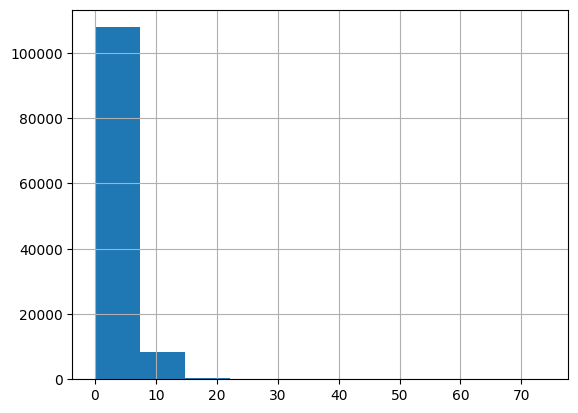

In [ ]:
h0 = train_df[train_df['holiday'] == 0]['uenomax']
h1 = train_df[train_df['holiday'] == 1]['uenomax']
h0.hist()

<Axes: >

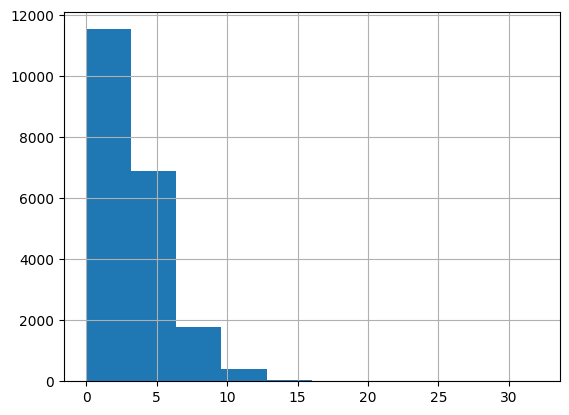

In [ ]:
h1.hist()

# 모델링

In [14]:
X, y = train_df.iloc[:, 2:-1], train_df.iloc[:, [-1]]

# train : valid = 7 : 3 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle = False, random_state = 30)
print(X_train.shape, X_valid.shape)

(96213, 36) (41235, 36)


In [21]:
X_train.head()

,scgfailratio,erabaddatt,erabaddratio,endcaddatt,endcaddratio,endcmodbymenbatt,endcmodbymenbratio,endcmodbysgnbatt,endcmodbysgnbratio,connestabatt,...,bler_dl,rachpreamblea,nummsg3,attpaging,rssipathavg,dlreceivedcqiavg,endcrelbymenb,holiday,cos_time,sin_time
0,0.0,9,100.0,5,100.0,2,100.0,7,100.0,1,...,6.4,17.0,11.0,2083.0,-92.8,11.2,3,0,1.0,0.0
1,8.3,12,100.0,9,100.0,0,0.0,15,100.0,1,...,2.4,19.0,15.0,1936.0,-92.8,10.7,11,0,1.0,0.0
2,0.0,9,100.0,8,100.0,4,100.0,11,100.0,10,...,9.9,28.0,23.0,1874.0,-92.7,10.7,5,0,1.0,0.0
3,0.0,11,100.0,10,100.0,0,0.0,8,100.0,2,...,5.0,16.0,14.0,1815.0,-92.6,9.4,8,0,1.0,0.0
4,0.0,9,100.0,8,100.0,0,0.0,9,100.0,0,...,0.6,14.0,10.0,1784.0,-92.8,9.6,8,0,1.0,0.0


In [22]:
# scaling
ss = StandardScaler()

not_hoilday = [col for col in X_train.columns if col not in ['hoilday']]

selected_col = X_train[not_hoilday]

X_train_scale = ss.fit_transform(X_train[not_hoilday])
X_valid_scale = ss.transform(X_valid[not_hoilday])
X_train_scale

array([[-0.35944831, -0.73210978,  0.08853298, ..., -0.65361862,
         1.41592072, -0.00605489],
       [ 1.09785358, -0.60917077,  0.08853298, ..., -0.65361862,
         1.41592072, -0.00605489],
       [-0.35944831, -0.73210978,  0.08853298, ..., -0.65361862,
         1.41592072, -0.00605489],
       ...,
       [-0.35944831,  0.53825997,  0.08853298, ..., -0.65361862,
         0.00279977, -1.42139512],
       [ 0.07949805,  0.53825997,  0.08853298, ..., -0.65361862,
         0.00279977, -1.42139512],
       [ 0.39553942,  0.78413798,  0.08853298, ..., -0.65361862,
         0.36854238, -1.37316857]])

### Optuna 튜닝

##### best였지만 지금은 아님

In [ ]:
def objectiveXGB(trial: Trial, X_train, y_train, X_valid, y_valid):
    param = {
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'gamma': trial.suggest_discrete_uniform('gamma', 0.01, 0.5, 0.01),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
        'nthread' : -1,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0] ),
        'random_state': 1
    }

    model = XGBRegressor(**param)
    xgb_model = model.fit(X_train, y_train, verbose = False,
                          eval_metric = 'mae', eval_set = [(X_valid, y_valid)], early_stopping_rounds = 100)

    ## MAE로 Loss 계산
    score = mean_absolute_error(xgb_model.predict(X_valid), y_valid)

    return score

In [ ]:
study = optuna.create_study(direction = 'minimize', sampler = TPESampler())

study.optimize(lambda trial : objectiveXGB(trial, X_train_scale, y_train, X_valid_scale, y_valid), n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

[I 2023-08-22 14:41:05,875] A new study created in memory with name: no-name-28a30517-3aa6-4358-b91b-46a8d5d356e8
[W 2023-08-22 14:41:06,565] Trial 0 failed with parameters: {'n_estimators': 3692, 'max_depth': 13, 'min_child_weight': 36, 'gamma': 0.38, 'learning_rate': 0.017515106549590608, 'colsample_bytree': 0.7, 'subsample': 1.0} because of the following error: XGBoostError('[14:41:06] ../src/gbm/gbtree.cc:568: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.\nStack trace:\n  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x2a7e13) [0x7d41f32a7e13]\n  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x2ab010) [0x7d41f32ab010]\n  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x2ab52a) [0x7d41f32ab52a]\n  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x2e03c7) [0x7d41f32e03c7]\n  [bt] (4) /usr/local/lib/python3.10/dist-packages

[14:41:06] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


XGBoostError: ignored

In [ ]:
xgboost1 = XGBRegressor(random_state = 1,
                        **study.best_trial.params)

In [ ]:
xgboost1.fit(X_train_scale, y_train,
             eval_metric = 'mae', eval_set = [(X_valid_scale, y_valid)], early_stopping_rounds = 100,
             verbose = 100)

[0]	validation_0-mae:1.81564
[100]	validation_0-mae:1.56868
[200]	validation_0-mae:1.35534
[300]	validation_0-mae:1.17606
[400]	validation_0-mae:1.02951
[500]	validation_0-mae:0.90856
[600]	validation_0-mae:0.81002
[700]	validation_0-mae:0.73072
[800]	validation_0-mae:0.66827
[900]	validation_0-mae:0.62009
[1000]	validation_0-mae:0.58360
[1100]	validation_0-mae:0.55676
[1200]	validation_0-mae:0.53720
[1300]	validation_0-mae:0.52334
[1400]	validation_0-mae:0.51373
[1500]	validation_0-mae:0.50715
[1600]	validation_0-mae:0.50289
[1700]	validation_0-mae:0.50026
[1800]	validation_0-mae:0.49883
[1900]	validation_0-mae:0.49840
[2000]	validation_0-mae:0.49846
[2049]	validation_0-mae:0.49868


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001413461234193065,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=3009, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [ ]:
y_pred = xgboost1.predict(X_valid_scale)
valid_mae = mean_absolute_error(y_valid, y_pred)
print('valid set에서의 mae :', valid_mae)

valid set에서의 mae : 0.49835057730801297


##### trials 더 많이

best score

In [25]:
def objectiveXGB(trial: Trial, X_train, y_train, X_valid, y_valid):
    param = {
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'gamma': trial.suggest_discrete_uniform('gamma', 0.01, 0.5, 0.01),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10),
        'nthread' : 1,
        'tree_method': 'hist',
        'predictor': 'cpu_predictor',
        'random_state': 1
    }

    model = XGBRegressor(**param)
    xgb_model = model.fit(X_train, y_train, verbose = False,
                          eval_metric = 'mae', eval_set = [(X_valid, y_valid)], early_stopping_rounds = 100)

    ## MAE로 Loss 계산
    score = mean_absolute_error(xgb_model.predict(X_valid), y_valid)

    return score

In [26]:
study = optuna.create_study(direction = 'minimize', sampler = TPESampler())

study.optimize(lambda trial : objectiveXGB(trial, X_train_scale, y_train, X_valid_scale, y_valid), n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

[I 2023-08-22 14:55:08,645] A new study created in memory with name: no-name-80d28414-c78d-45eb-8c43-047621b78a60
[I 2023-08-22 14:55:58,553] Trial 0 finished with value: 0.5255197222961054 and parameters: {'n_estimators': 3078, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.39, 'learning_rate': 0.003778636982734191, 'colsample_bytree': 1.0, 'subsample': 0.9, 'lambda': 0.0023939357865410756, 'alpha': 9.200710777421886}. Best is trial 0 with value: 0.5255197222961054.
[I 2023-08-22 14:58:54,967] Trial 1 finished with value: 0.5033506620197186 and parameters: {'n_estimators': 3290, 'max_depth': 11, 'min_child_weight': 30, 'gamma': 0.04, 'learning_rate': 0.0015371786741807485, 'colsample_bytree': 0.8, 'subsample': 0.6, 'lambda': 1.9746817299111212, 'alpha': 0.005270021338442792}. Best is trial 1 with value: 0.5033506620197186.
[I 2023-08-22 14:59:45,725] Trial 2 finished with value: 0.5293518898901801 and parameters: {'n_estimators': 2092, 'max_depth': 5, 'min_child_weight': 16, 'gamma

Best trial: score 0.4941761515029538,
params {'n_estimators': 1986, 'max_depth': 17, 'min_child_weight': 3, 'gamma': 0.4, 'learning_rate': 0.0017418519496536352, 'colsample_bytree': 0.9, 'subsample': 0.7, 'lambda': 6.931130557249856, 'alpha': 0.022000014997788992}


In [27]:
xgboost1 = XGBRegressor(random_state = 1,
                        **study.best_trial.params)

In [28]:
xgboost1.fit(X_train_scale, y_train,
             eval_metric = 'mae', eval_set = [(X_valid_scale, y_valid)], early_stopping_rounds = 100,
             verbose = 100)

[0]	validation_0-mae:1.81504
[100]	validation_0-mae:1.51178
[200]	validation_0-mae:1.26141
[300]	validation_0-mae:1.06373
[400]	validation_0-mae:0.90973
[500]	validation_0-mae:0.79072
[600]	validation_0-mae:0.70115
[700]	validation_0-mae:0.63595
[800]	validation_0-mae:0.58965
[900]	validation_0-mae:0.55739
[1000]	validation_0-mae:0.53530
[1100]	validation_0-mae:0.52027
[1200]	validation_0-mae:0.51033
[1300]	validation_0-mae:0.50366
[1400]	validation_0-mae:0.49937
[1500]	validation_0-mae:0.49665
[1600]	validation_0-mae:0.49510
[1700]	validation_0-mae:0.49429
[1800]	validation_0-mae:0.49409
[1900]	validation_0-mae:0.49419
[1911]	validation_0-mae:0.49423


XGBRegressor(alpha=0.022000014997788992, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=6.931130557249856,
             learning_rate=0.0017418519496536352, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=1986, n_jobs=None, num_parallel_tree=None, ...)

In [29]:
y_pred = xgboost1.predict(X_valid_scale)
valid_mae = mean_absolute_error(y_valid, y_pred)
print('valid set에서의 mae :', valid_mae)

valid set에서의 mae : 0.49406503902440385


In [30]:
def predict_df(model) :
  label_sample = pd.read_csv('Q1_label_sample.csv')

  StationB = test_df[test_df['ru_id'] == 'BaseStationB'].iloc[:, 2:]
  StationJ = test_df[test_df['ru_id'] == 'BaseStationJ'].iloc[:, 2:]

  B_scale = ss.transform(StationB)
  B_pred = model.predict(B_scale)

  J_scale = ss.transform(StationJ)
  J_pred = model.predict(J_scale)

  label_sample['BaseStationB'] = B_pred
  label_sample['BaseStationJ'] = J_pred

  return label_sample

In [31]:
label_sample = predict_df(xgboost1)

In [32]:
label_sample.to_csv('xgb_preprocessing_time_Variable_holiday56.csv', index = False)

### 변수 drop 버전

##### 1.

In [ ]:
drop_list = ['reestabatt', 'handoverratio', 'redirectiontolte_epsfallback', 'redirectiontolte_coverageout', 'endcaddratio', 'reestabratio',
             'connestabratio', 'handoveratt', 'endcmodbysgnbratio', 'endcaddatt', 'rssipathavg',
             'airmacdlbyte',
             'endcmodbysgnbatt',
             'scgfailratio',
             'connestabatt']

In [ ]:
X_train_drop = X_train.drop(drop_list, axis = 1)
X_valid_drop = X_valid.drop(drop_list, axis = 1)

In [ ]:
# scaling
ss = StandardScaler()

X_train_scale2 = ss.fit_transform(X_train_drop)
X_valid_scale2 = ss.transform(X_valid_drop)

In [ ]:
study2 = optuna.create_study(direction = 'minimize', sampler = TPESampler())

study2.optimize(lambda trial : objectiveXGB(trial, X_train_scale2, y_train, X_valid_scale2, y_valid), n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study2.best_trial.value,study2.best_trial.params))

In [ ]:
xgboost3 = XGBRegressor(random_state = 1,
                        **study2.best_trial.params)

In [ ]:
xgboost3.fit(X_train_scale2, y_train,
             eval_metric = 'mae', eval_set = [(X_valid_scale2, y_valid)], early_stopping_rounds = 100,
             verbose = 100)

In [ ]:
y_pred = xgboost3.predict(X_valid_scale2)
valid_mae = mean_absolute_error(y_valid, y_pred)
print('valid set에서의 mae :', valid_mae)

##### 2.

In [ ]:
drop_list = ['reestabatt', 'handoverratio', 'redirectiontolte_epsfallback', 'redirectiontolte_coverageout', 'endcaddratio', 'reestabratio',
             'connestabratio', 'handoveratt', 'endcmodbysgnbratio', 'endcaddatt', 'rssipathavg',
             'airmacdlbyte',
             'endcmodbysgnbatt']

In [ ]:
X_train_drop = X_train.drop(drop_list, axis = 1)
X_valid_drop = X_valid.drop(drop_list, axis = 1)

In [ ]:
# scaling
ss = StandardScaler()

X_train_scale2 = ss.fit_transform(X_train_drop)
X_valid_scale2 = ss.transform(X_valid_drop)

In [ ]:
study2 = optuna.create_study(direction = 'minimize', sampler = TPESampler())

study2.optimize(lambda trial : objectiveXGB(trial, X_train_scale2, y_train, X_valid_scale2, y_valid), n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study2.best_trial.value,study2.best_trial.params))

In [ ]:
xgboost4 = XGBRegressor(random_state = 1,
                        **study2.best_trial.params)

In [ ]:
xgboost4.fit(X_train_scale2, y_train,
             eval_metric = 'mae', eval_set = [(X_valid_scale2, y_valid)], early_stopping_rounds = 100,
             verbose = 100)

In [ ]:
y_pred = xgboost4.predict(X_valid_scale2)
valid_mae = mean_absolute_error(y_valid, y_pred)
print('valid set에서의 mae :', valid_mae)

In [ ]:
def predict_df(model) :
  label_sample = pd.read_csv('Q1_data/Q1_label_sample.csv')

  StationB = test_df[test_df['ru_id'] == 'BaseStationB'].iloc[:, 2:]
  StationJ = test_df[test_df['ru_id'] == 'BaseStationJ'].iloc[:, 2:]

  B_scale = ss.transform(StationB.drop(drop_list, axis = 1))
  B_pred = model.predict(B_scale)

  J_scale = ss.transform(StationJ.drop(drop_list, axis = 1))
  J_pred = model.predict(J_scale)

  label_sample['BaseStationB'] = B_pred
  label_sample['BaseStationJ'] = J_pred

  return label_sample

In [ ]:
label_sample = predict_df(xgboost4)

In [ ]:
label_sample.to_csv('Q1_data/xgb_drop_optuna.csv', index = False)